In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('png')
plt.rcParams['figure.dpi'] = 300 
plt.rcParams['savefig.dpi'] = 300
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import torch

In [38]:
data = pd.read_csv('/Users/youkipepper/Desktop/torch/data_hn/hn_01-02/hn_01-02_2024-01-25.csv', usecols= [3]).values.reshape(-1)
data.shape

(2007,)

In [39]:
predict_step = 15
predict_num = 1
data_set = []
for i in range(data.shape[0] - predict_step - predict_num):
    data_set.append(data[i:i+predict_step+predict_num])
data_set = np.array(data_set)
data_set.shape

(1991, 16)

In [40]:
# train_set, test_set = data_set[:int(data_set.shape[0]*0.7)], data_set[int(data_set.shape[0]*0.7):]
train_set, test_set = train_test_split(data_set, test_size= 0.3, shuffle= False)
train_set.shape, test_set.shape

((1393, 16), (598, 16))

In [41]:
x_train, y_train_original = train_set[:, :-predict_num], train_set[:, -predict_num:].reshape(-1, 1)
x_test, y_test_original = test_set[:, :-predict_num], test_set[:, -predict_num:].reshape(-1, 1)
x_train.shape, y_train_original.shape, x_test.shape, y_test_original.shape

((1393, 15), (1393, 1), (598, 15), (598, 1))

In [42]:
# normalize
scaler = MinMaxScaler(feature_range=(0, 1))
x_train = scaler.fit_transform(x_train)
y_train_original = scaler.fit_transform(y_train_original)
x_test = scaler.fit_transform(x_test)
y_test_original = scaler.fit_transform(y_test_original)

In [43]:
x_train = torch.tensor(x_train, dtype= torch.float32)
y_train_original = torch.tensor(y_train_original, dtype= torch.float32)
x_test = torch.tensor(x_test, dtype= torch.float32)
y_test_original = torch.tensor(y_test_original, dtype= torch.float32)
x_train.shape, y_train_original.shape, x_test.shape, y_test_original.shape

(torch.Size([1393, 15]),
 torch.Size([1393, 1]),
 torch.Size([598, 15]),
 torch.Size([598, 1]))

In [44]:
# define model
class TreeModel(torch.nn.Module):
    def __init__(self, input_size, output_size, trees= 100, min_leaf= 5):
        super().__init__()
        self.trees = trees
        self.min_leaf = min_leaf
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(input_size, trees),
            torch.nn.ReLU(),
            torch.nn.Linear(trees, output_size)
        )

    def forward(self, x):
        return self.fc(x)
    
model = TreeModel(input_size= x_train.shape[1], output_size= predict_num)

In [45]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr= 0.01)


In [46]:
# train model
epochs = 1000
losses = []
for epoch in range (epochs):
    optimizer.zero_grad()
    y_pred = model(x_train)
    loss = criterion(y_pred, y_train_original)
    loss.backward()
    losses.append(loss.item())
    optimizer.step()
    if epoch % 100 == 0:
        print(f'Epoch {epoch} loss: {loss.item()}')

Epoch 0 loss: 0.49268674850463867
Epoch 100 loss: 0.006460242439061403
Epoch 200 loss: 0.006372540257871151
Epoch 300 loss: 0.00630864268168807
Epoch 400 loss: 0.006264963187277317
Epoch 500 loss: 0.0062377261929214
Epoch 600 loss: 0.006220622919499874
Epoch 700 loss: 0.006208482664078474
Epoch 800 loss: 0.006196393631398678
Epoch 900 loss: 0.006186050362884998


In [47]:
res_train = model(x_train).detach().numpy()
res_test = model(x_test).detach().numpy()
res_train.shape, res_test.shape

((1393, 1), (598, 1))

In [48]:
res_train = scaler.inverse_transform(res_train).flatten()
res_test = scaler.inverse_transform(res_test).flatten()
y_train_original = scaler.inverse_transform(y_train_original).flatten()
y_test_original = scaler.inverse_transform(y_test_original).flatten()
res_train.shape, res_test.shape, y_train_original.shape, y_test_original.shape

((1393,), (598,), (1393,), (598,))

In [49]:
train_error = mean_squared_error(y_train_original, res_train)
test_error = mean_squared_error(y_test_original, res_test)

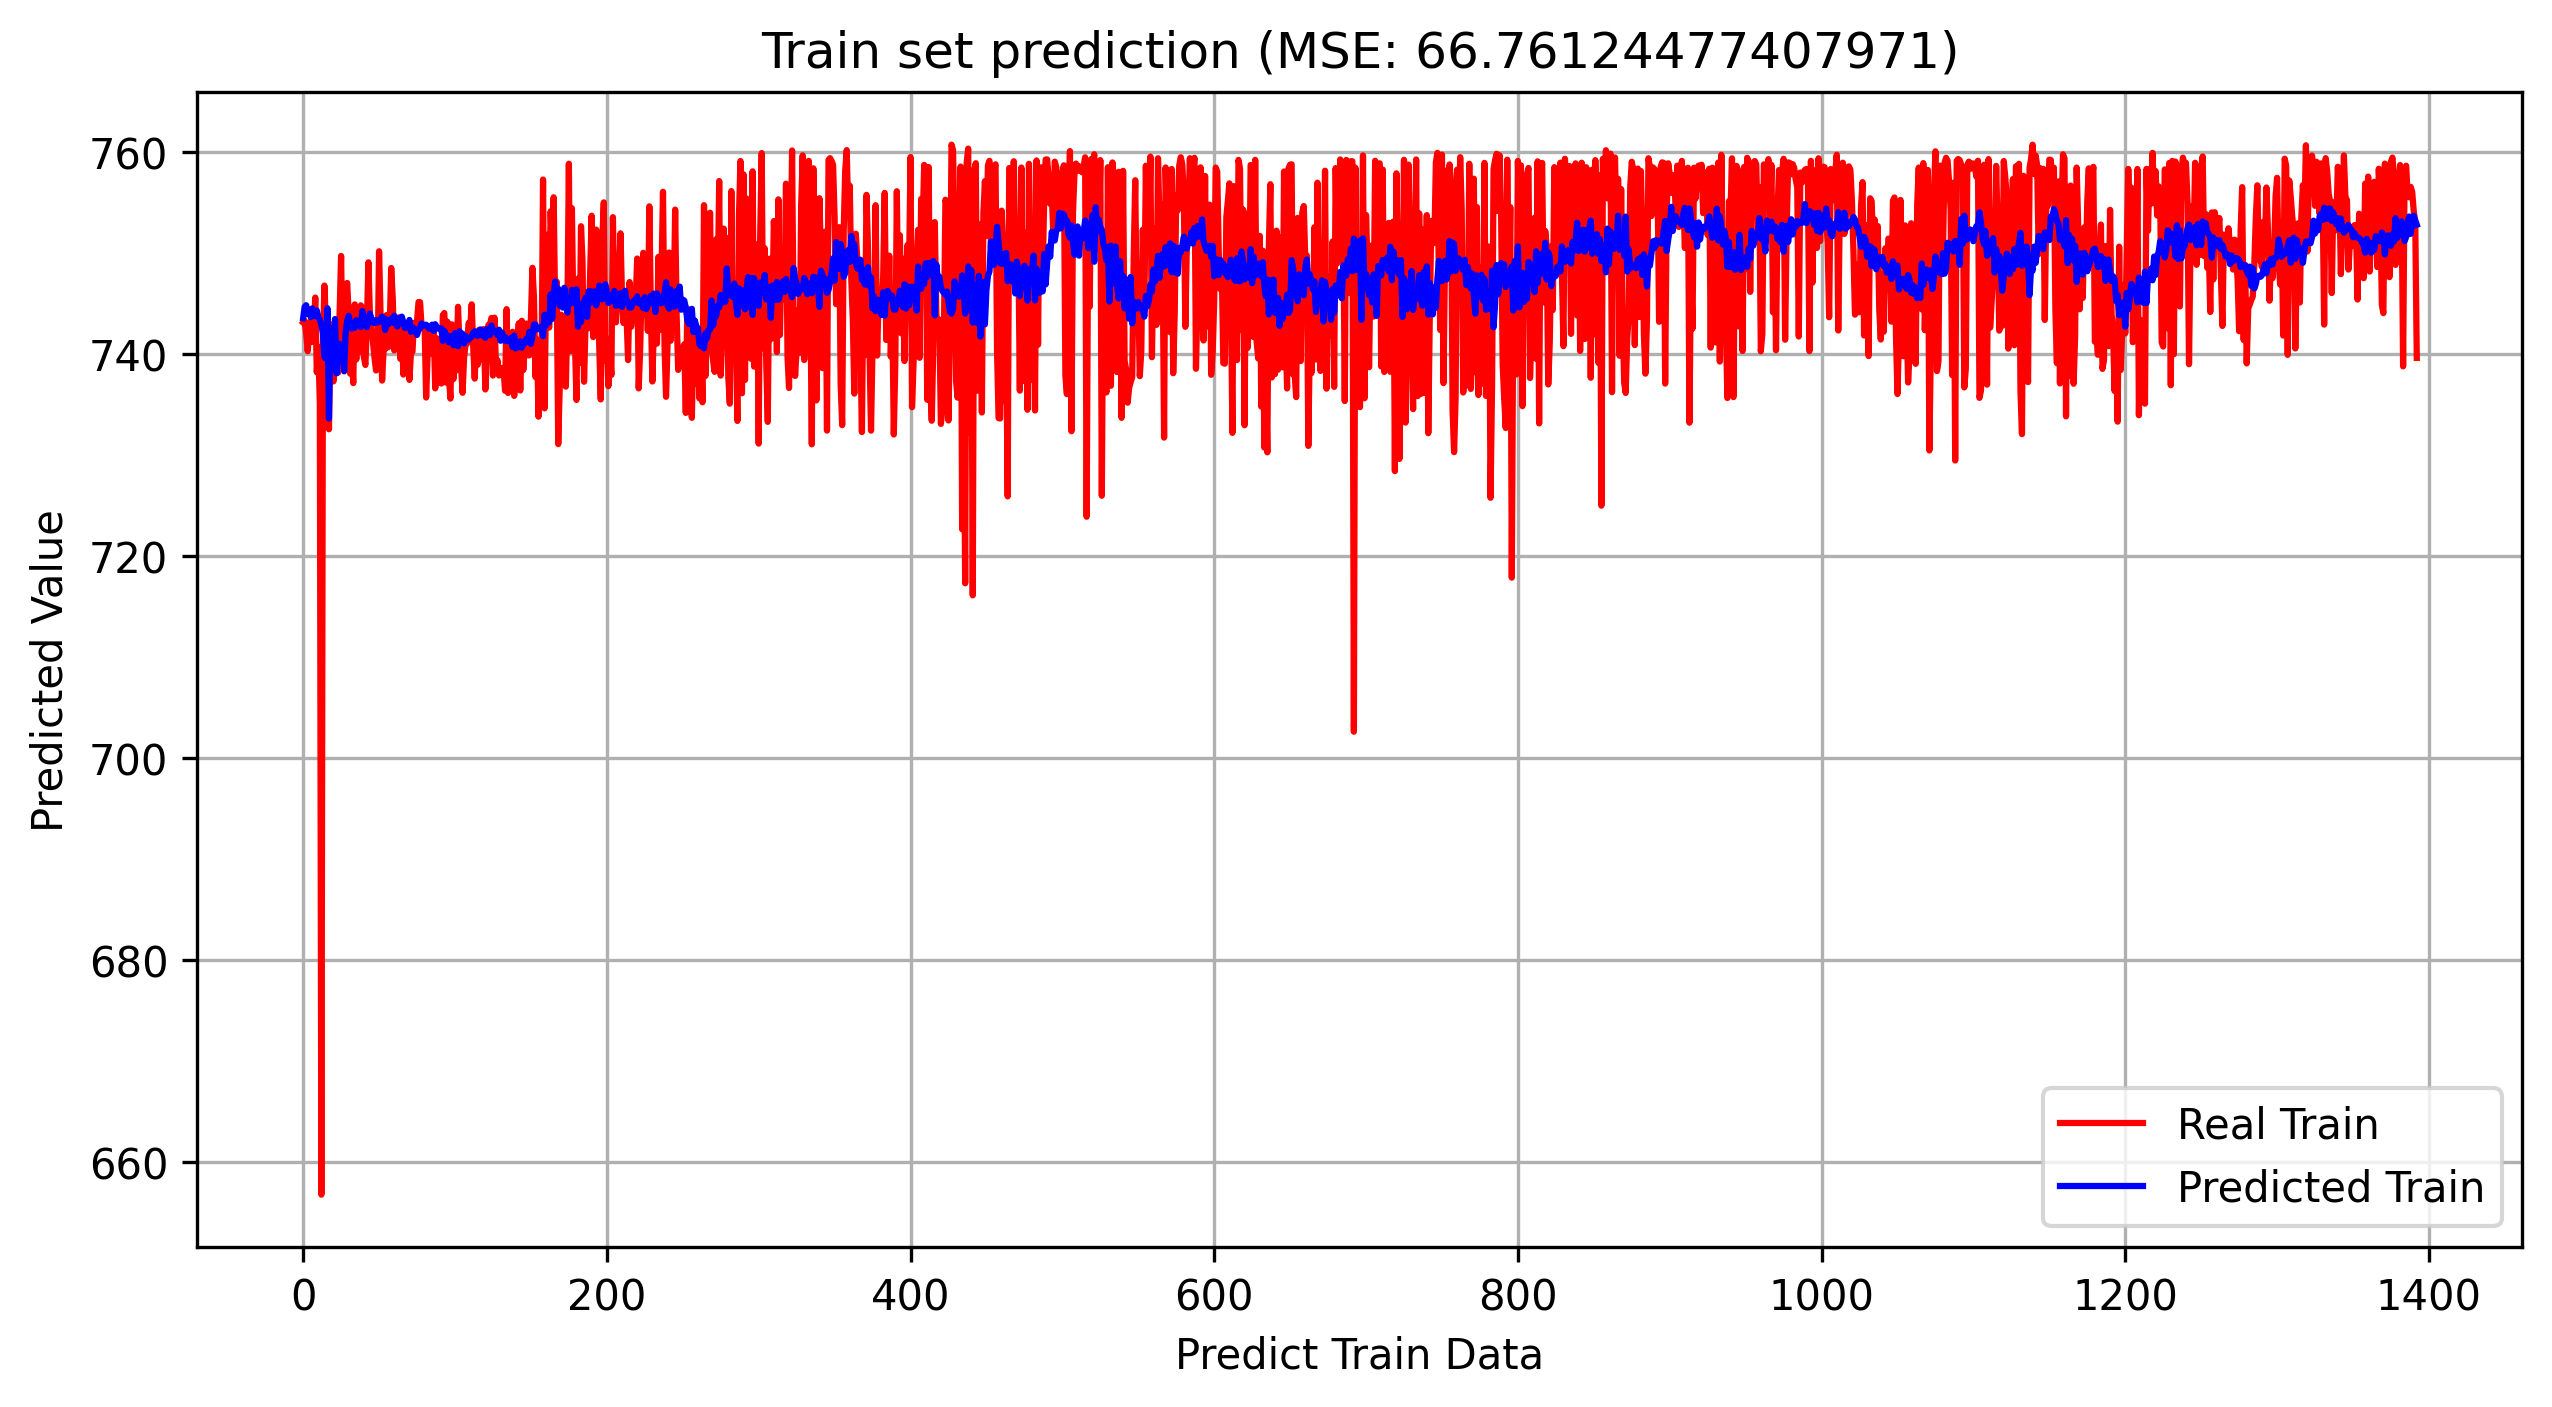

In [50]:
plt.figure(figsize=(10,5))
plt.plot(y_train_original, 'r-', label= 'Real Train')
plt.plot(res_train, 'b-', label = 'Predicted Train')
plt.legend()
plt.xlabel('Predict Train Data')
plt.ylabel('Predicted Value')
plt.title(f'Train set prediction (MSE: {train_error})')
plt.grid()
plt.show()

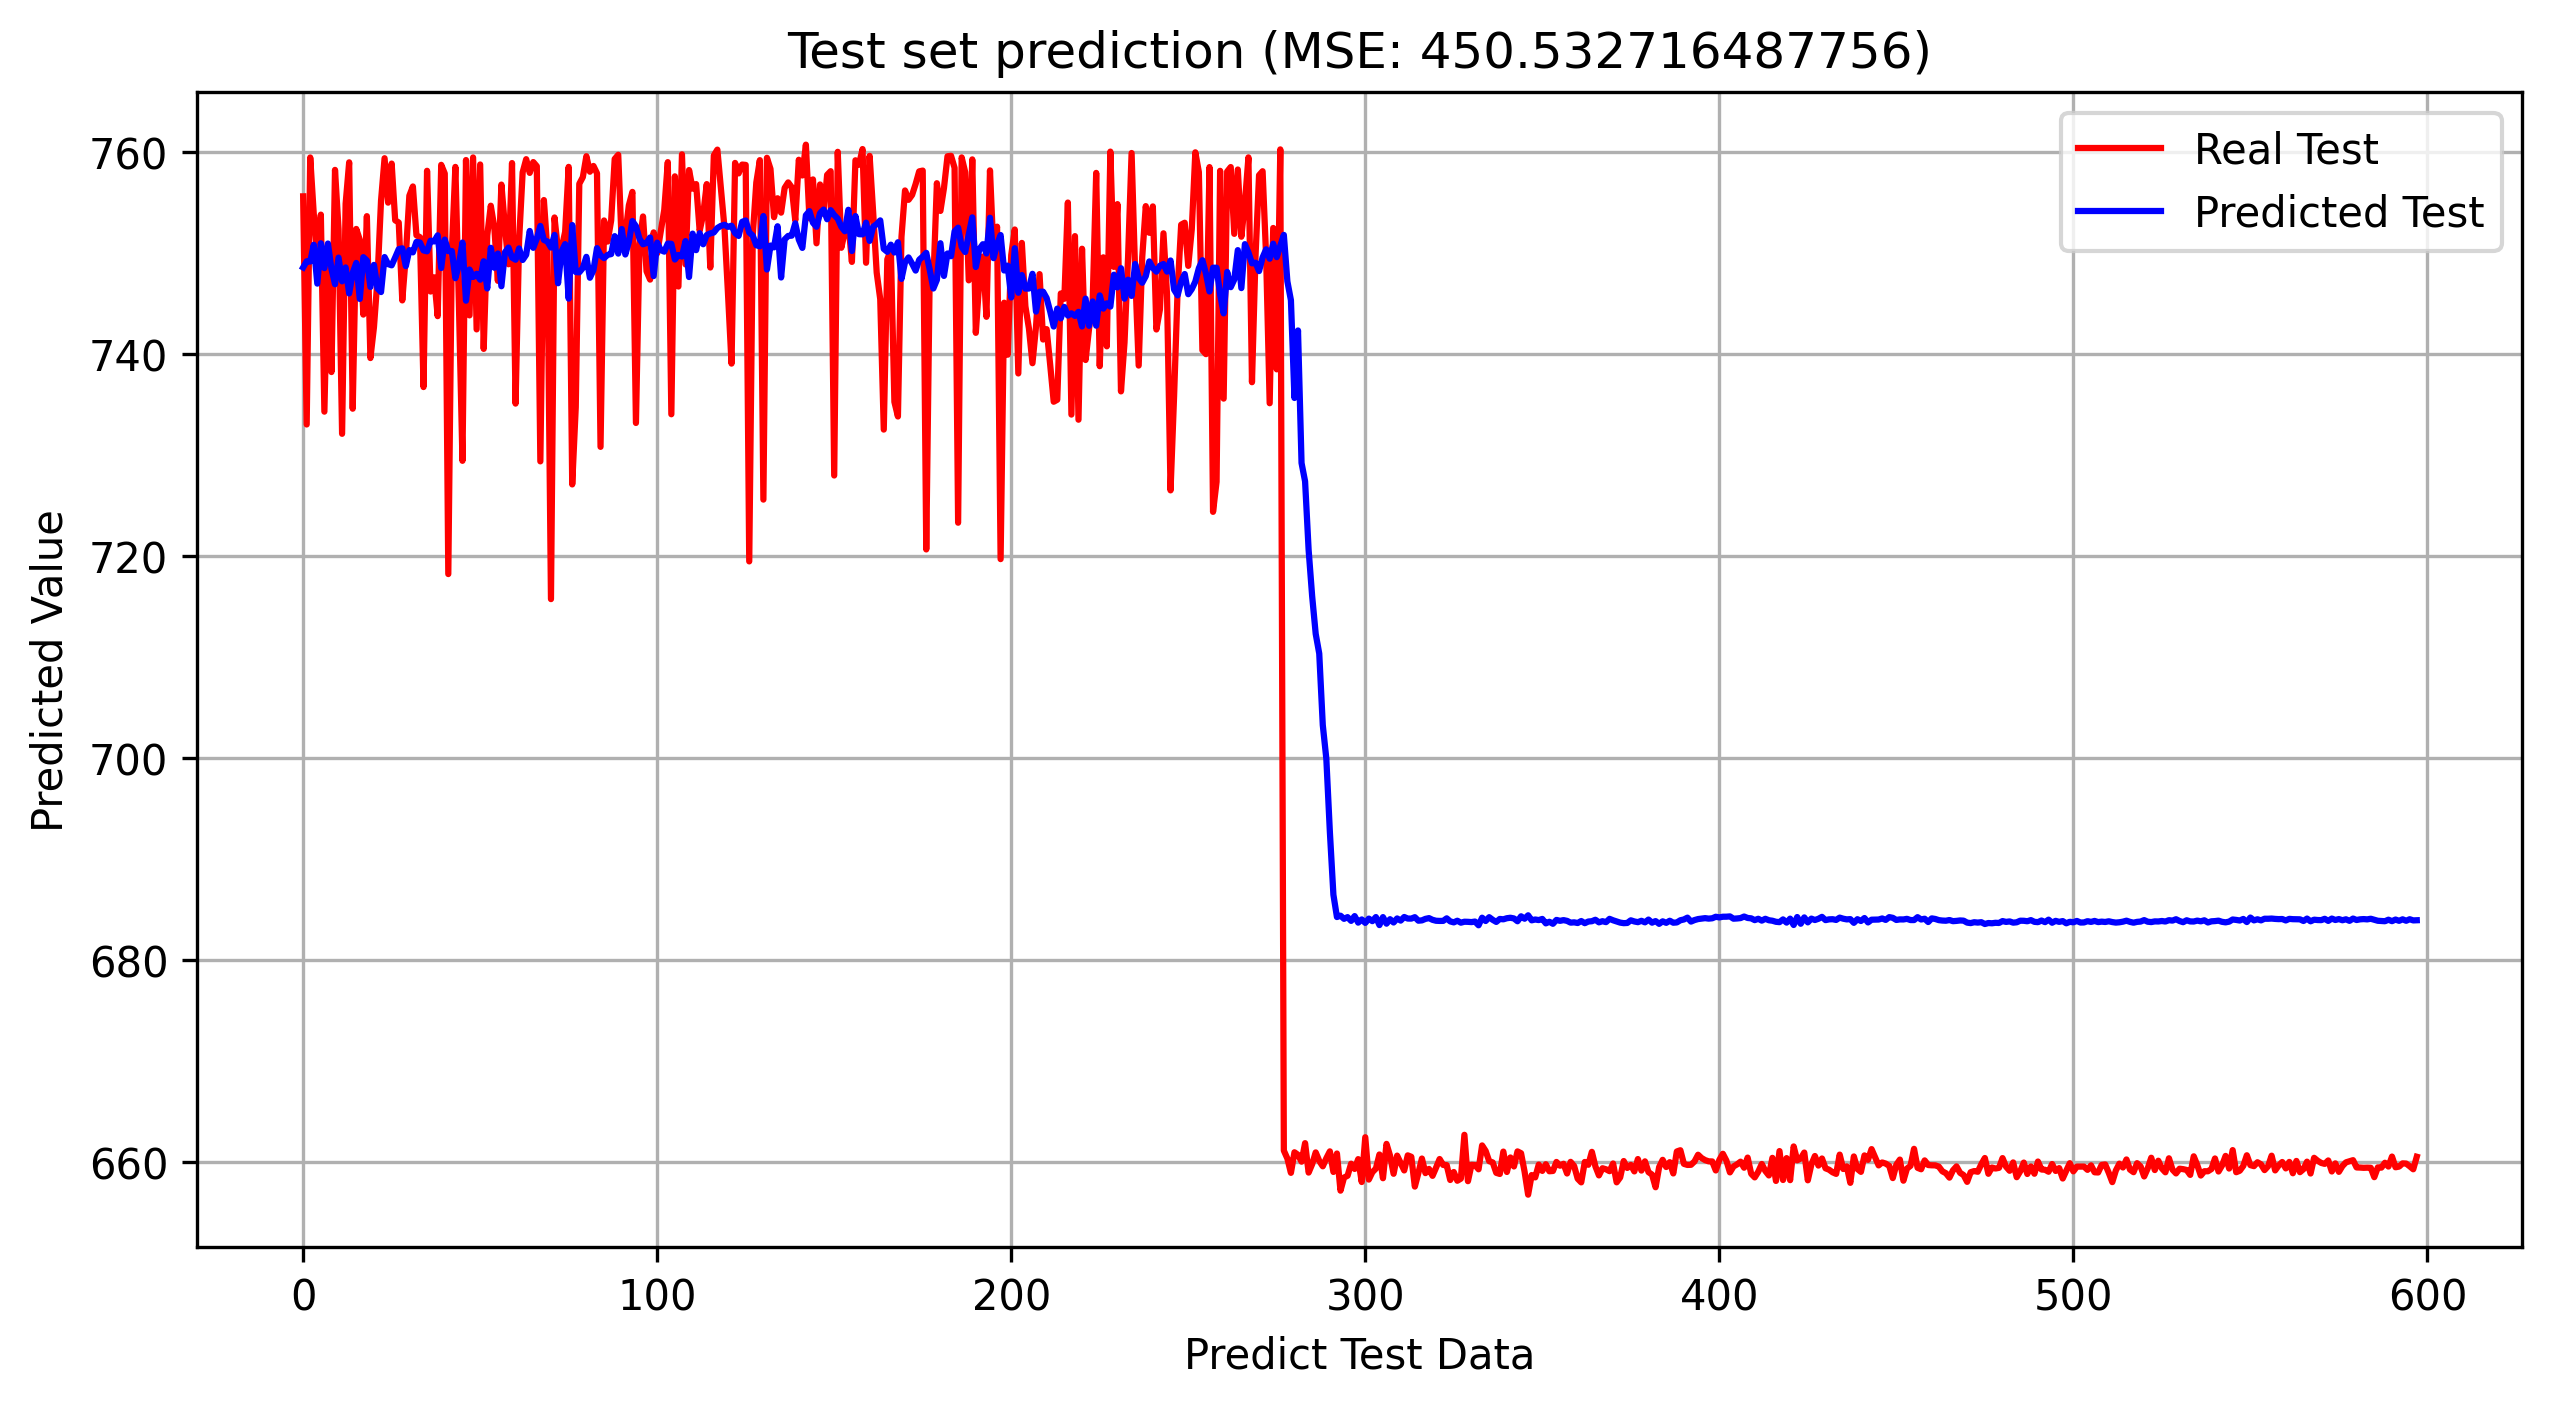

In [51]:
plt.figure(figsize=(10,5))
plt.plot(y_test_original, 'r-', label= 'Real Test')
plt.plot(res_test, 'b-', label = 'Predicted Test')
plt.legend()
plt.xlabel('Predict Test Data')
plt.ylabel('Predicted Value')
plt.title(f'Test set prediction (MSE: {test_error})')
plt.grid()
plt.show()

In [52]:
train_r2 = r2_score(y_train_original, res_train)
test_r2 = r2_score(y_test_original, res_test)
train_mae = mean_absolute_error(y_train_original, res_train)
test_mae = mean_absolute_error(y_test_original, res_test)
train_mbe = np.mean(y_train_original - res_train)
test_mbe = np.mean(y_test_original - res_test)
print(f'Train R2: {train_r2}, Test R2: {test_r2}')
print(f'Train MAE: {train_mae}, Test MAE: {test_mae}')
print(f'Train MBE: {train_mbe}, Test MBE: {test_mbe}')

Train R2: 0.1579467585987756, Test R2: 0.7812828946375829
Train MAE: 6.46024793669337, Test MAE: 17.371535787599132
Train MBE: 0.0009478824295599094, Test MBE: -13.891614430482381


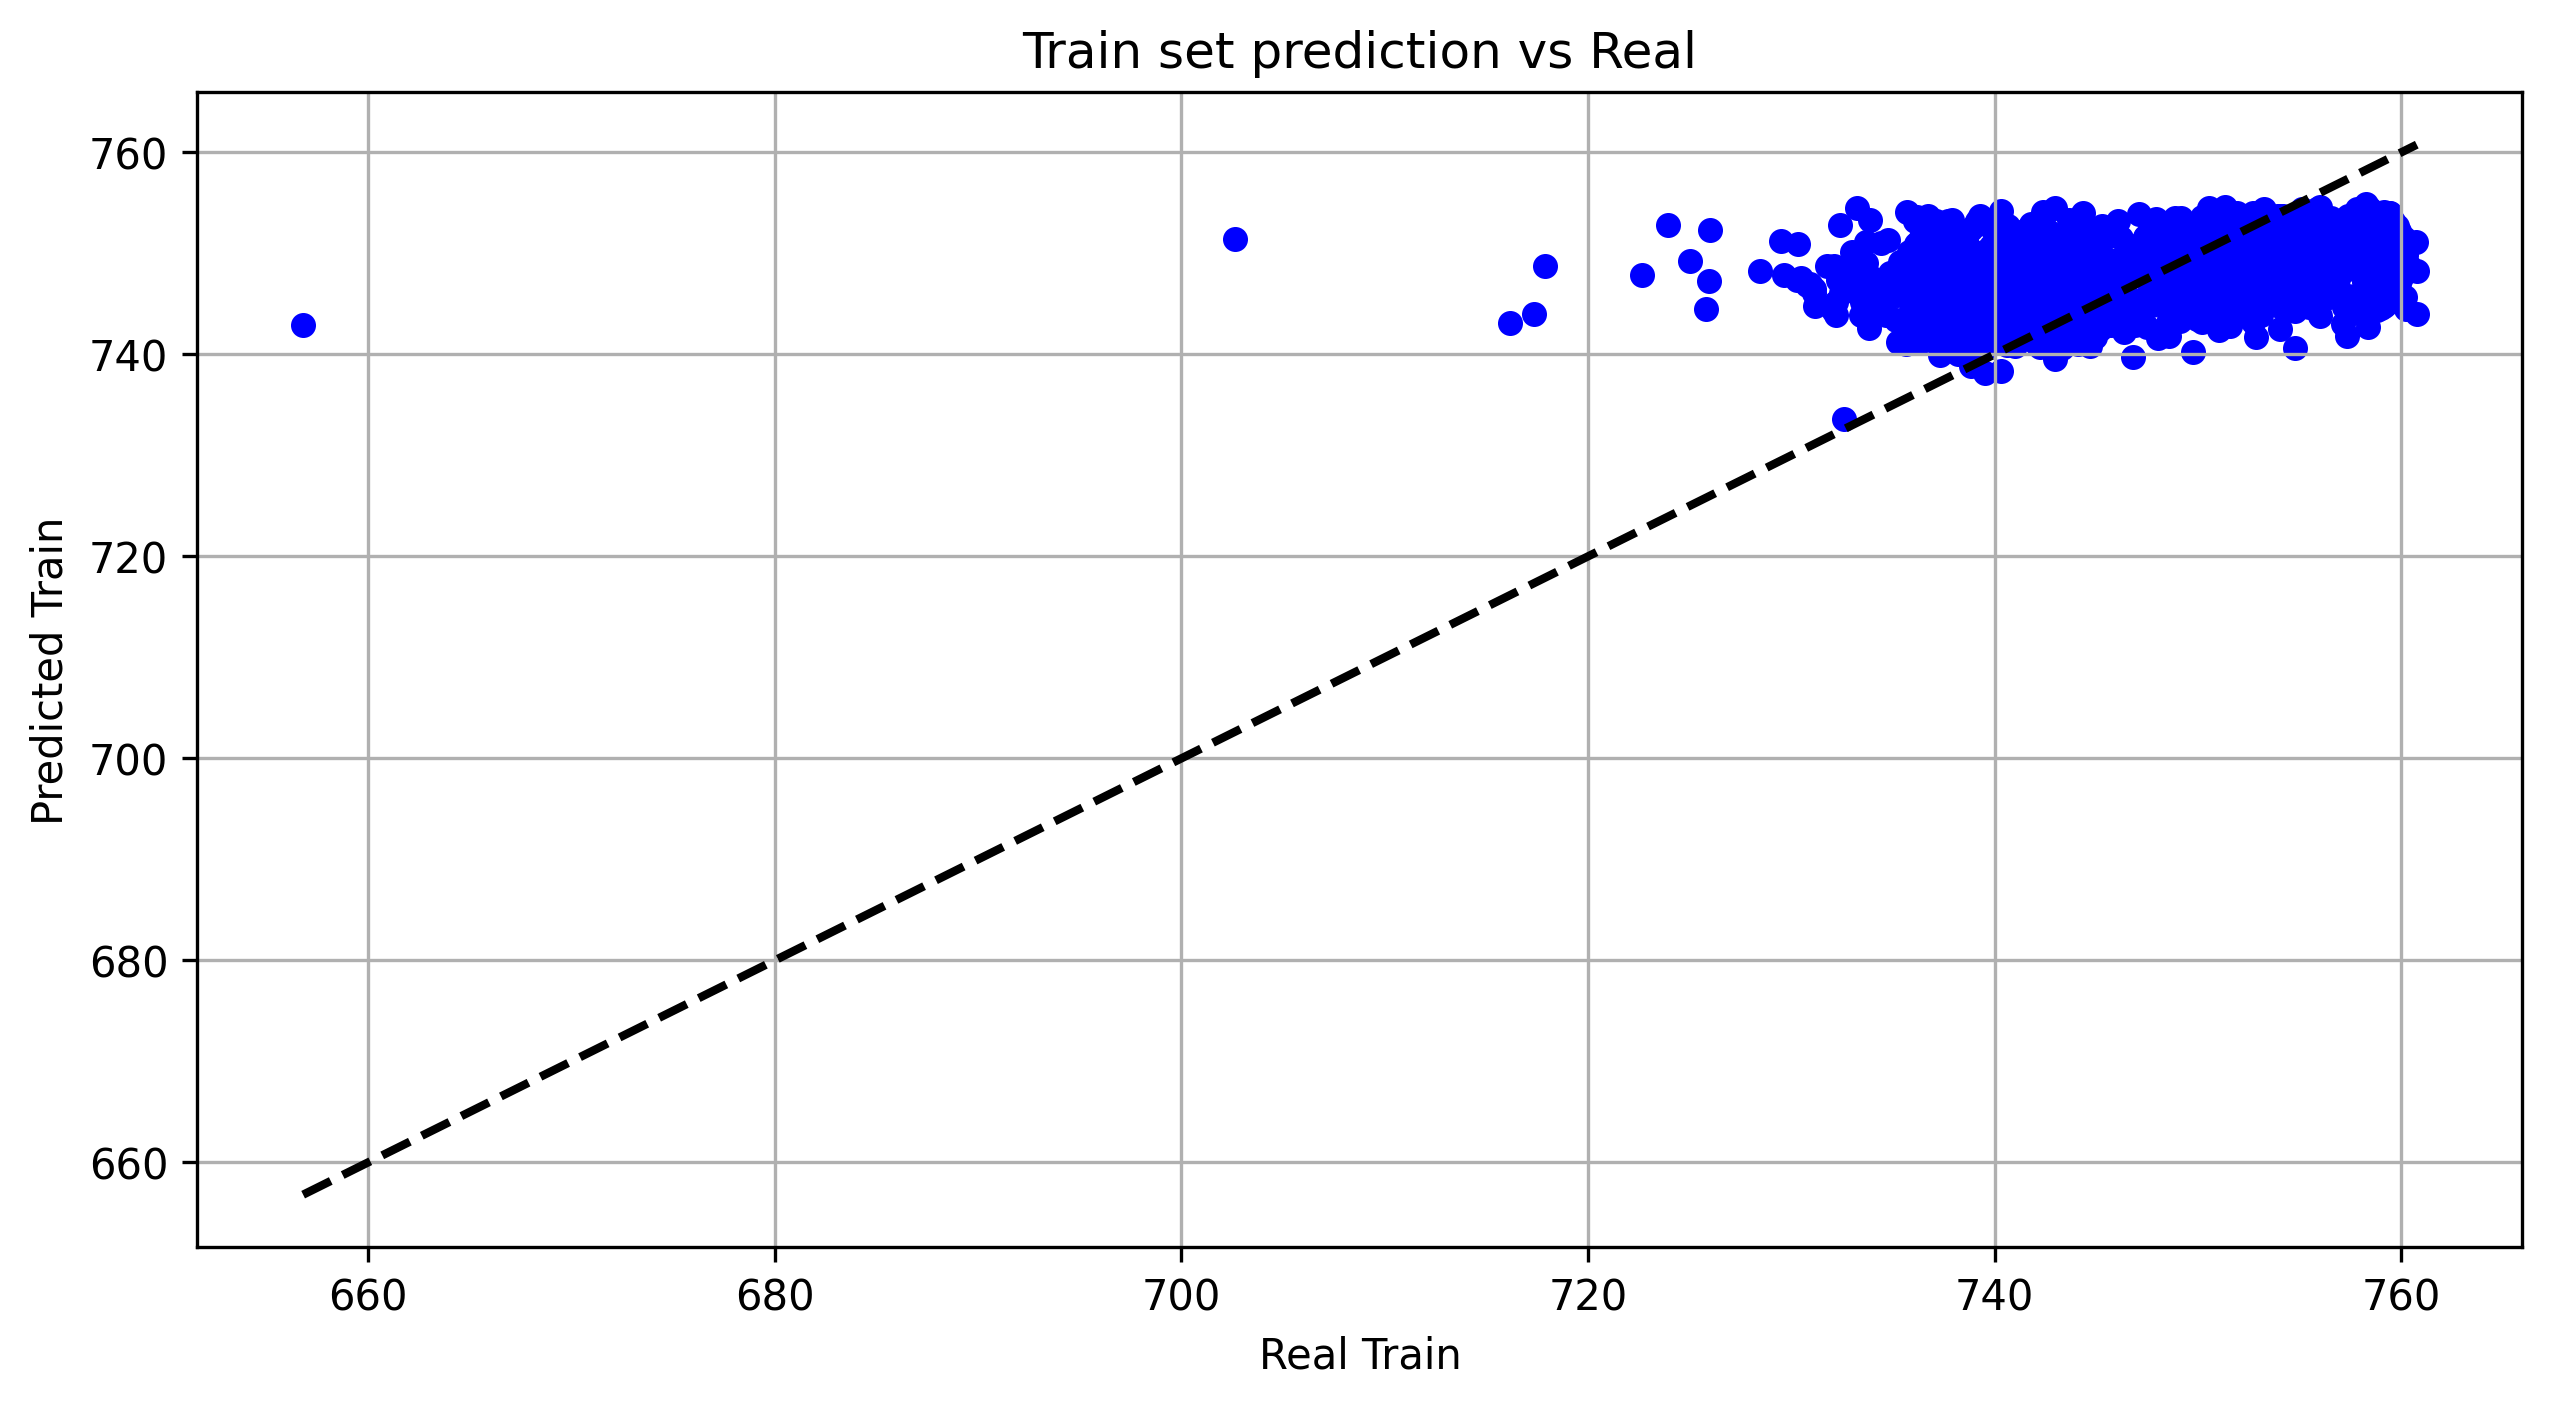

In [53]:
plt.figure(figsize=(10,5))
plt.scatter(y_train_original, res_train, c='b', s=25)
plt.plot([y_train_original.min(), y_train_original.max()], [y_train_original.min(), y_train_original.max()], 'k--', lw=2)
plt.xlabel('Real Train')
plt.ylabel('Predicted Train')
plt.title(f'Train set prediction vs Real')
plt.grid()
plt.show()

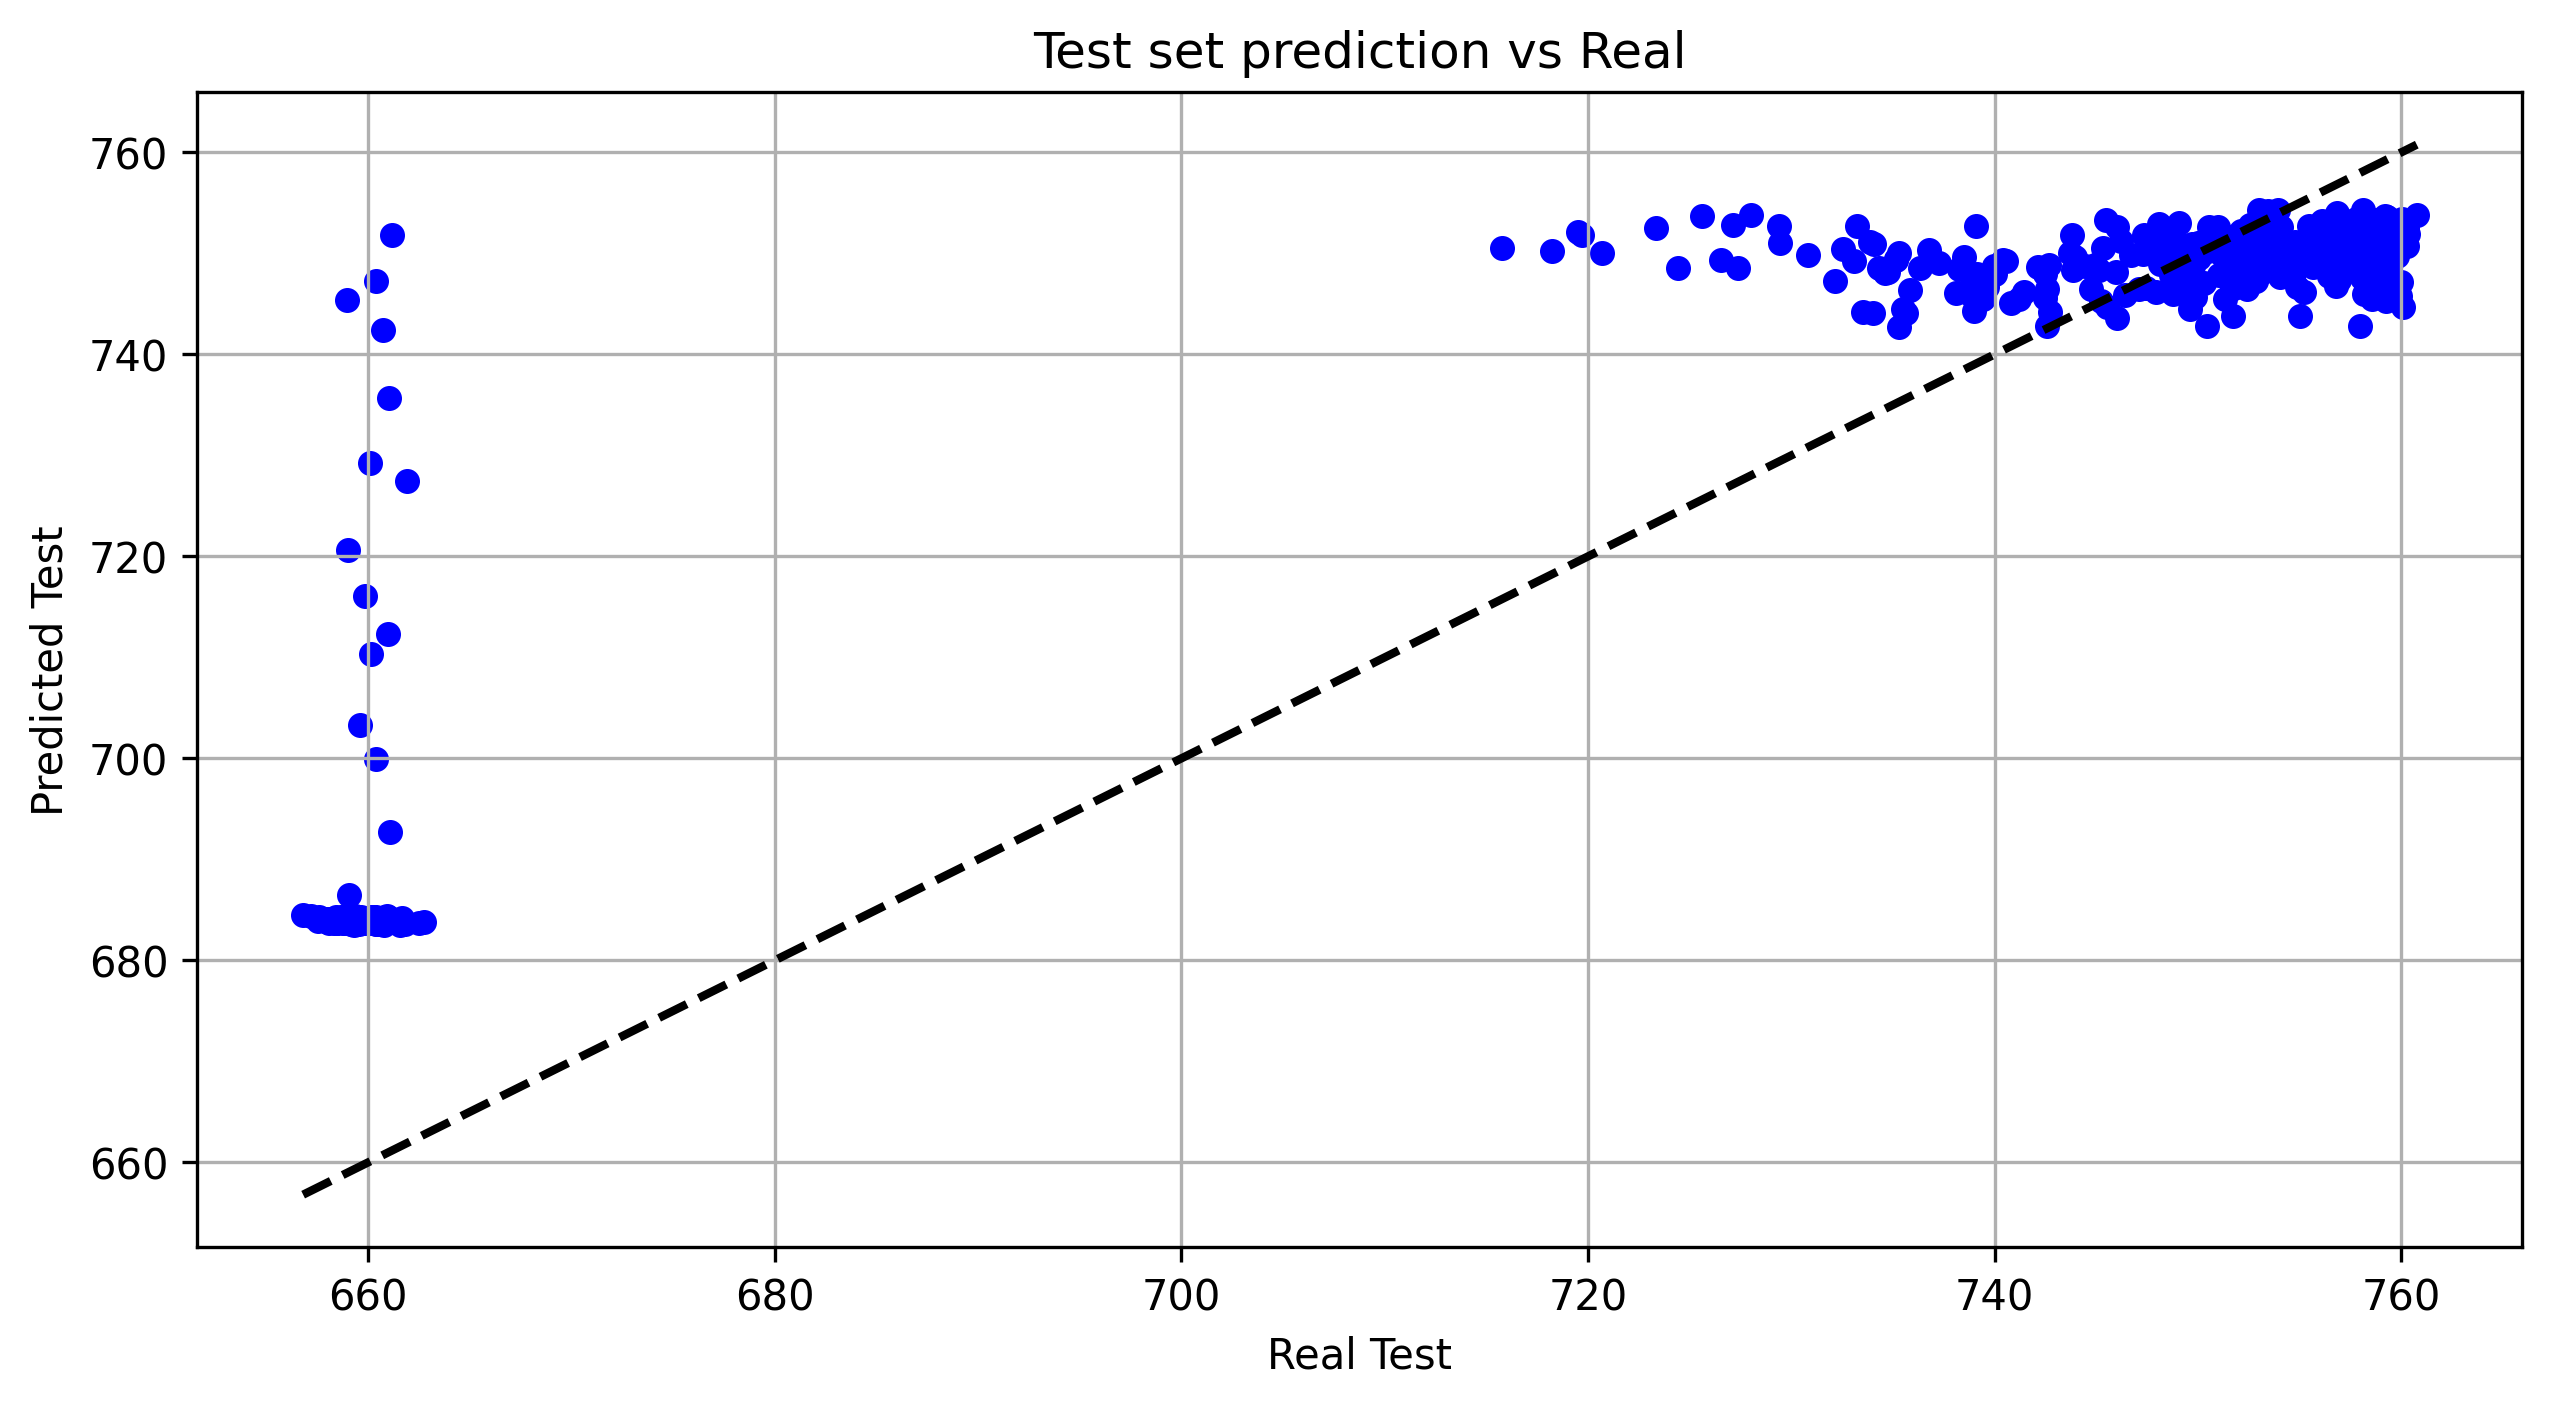

In [54]:
plt.figure(figsize=(10,5))
plt.scatter(y_test_original, res_test, c='b', s=25)
plt.plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], 'k--', lw=2)
plt.xlabel('Real Test')
plt.ylabel('Predicted Test')
plt.title(f'Test set prediction vs Real')
plt.grid()
plt.show()